<a href="https://colab.research.google.com/github/cindyhfls/NMA_DL_2021_project/blob/main/project_group_OkapisJohnV2_1RAB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


To-do: 

* helper functions to trim and bin data - 
* simple correlations
* visualization/summary of dataset
* build network?
* align spikes to move (0-500 ms after response)



In [6]:
# Data Loading

#@title Data retrieval
import os, requests

fname = []
for j in range(3):
  fname.append('steinmetz_part%d.npz'%j)
url = ["https://osf.io/agvxh/download"]
url.append("https://osf.io/uv3mw/download")
url.append("https://osf.io/ehmw2/download")

for j in range(len(url)):
  if not os.path.isfile(fname[j]):
    try:
      r = requests.get(url[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fname[j], "wb") as fid:
          fid.write(r.content)

In [27]:
#@title Import matplotlib and set defaults
from matplotlib import rcParams 
from matplotlib import pyplot as plt


import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import pyplot as plt
from torch.utils.data.dataloader import default_collate

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

In [8]:
#@title Data loading
import numpy as np

alldat = np.array([])
for j in range(len(fname)):
  alldat = np.hstack((alldat, np.load('steinmetz_part%d.npz'%j, allow_pickle=True)['dat']))

In [9]:
#@title Print Keys
print(alldat[0].keys())
#print(np.size(alldat[0].spks))


dict_keys(['spks', 'wheel', 'pupil', 'response', 'response_time', 'bin_size', 'stim_onset', 'contrast_right', 'contrast_left', 'brain_area', 'feedback_time', 'feedback_type', 'gocue', 'mouse_name', 'date_exp', 'trough_to_peak', 'active_trials', 'contrast_left_passive', 'contrast_right_passive', 'spks_passive', 'pupil_passive', 'wheel_passive', 'prev_reward', 'ccf', 'ccf_axes', 'cellid_orig', 'reaction_time', 'face', 'face_passive', 'licks', 'licks_passive'])


In [10]:
#@title Define Steinmetz Class
import copy
class SteinmetzSession:
  data = []
  binSize = 10
  nTrials = []
  nNeurons = []
  trialLen = 0
  trimStart = "trialStart"
  trimEnd =  "trialEnd"
  def __init__(self, dataIn):
    self.data = copy.deepcopy(dataIn)
    dims1 = np.shape(dataIn['spks'])
    self.nTrials = dims1[1]
    self.nNeurons = dims1[0]
    self.trialLen = dims1[2]

  def binData(self, binSizeIn): # Inputs: data, scalar for binning. Combines binSizeIn bins together to bin data smaller Ex. binSizeIn of 5 on the original dataset combines every 5 10 ms bins into one 50 ms bin across all trials.
    varsToRebinSum = ['spks']
    varsToRebinMean = ['wheel', 'pupil']
    spikes = self.data['spks']
    histVec = range(0,self.trialLen+1, binSizeIn)
    spikesBin = np.zeros((self.nNeurons, self.nTrials, len(histVec)))
    print(histVec)
    for trial in range(self.nTrials):
      spikes1 = np.squeeze(spikes[:,trial,:])
      for time1 in range(len(histVec)-1):
        spikesBin[:,trial, time1] = np.sum(spikes1[:, histVec[time1]:histVec[time1+1]-1], axis=1)

    spikesBin = spikesBin[:,:,:-1]
    self.data['spks'] = spikesBin
    self.trialLen = len(histVec) -1
    self.binSize = self.binSize*binSizeIn

    
    s = "Binned spikes, turning a " + repr(np.shape(spikes)) + " matrix into a " + repr(np.shape(spikesBin)) + " matrix"
    print(s)

  def plotTrial(self, trialNum): # Basic function to plot the firing rate during a single trial. Used for debugging trimming and binning
    plt.imshow(np.squeeze(self.data['spks'][:,trialNum,:])**.5, aspect = 'auto')
    plt.xlabel("Time (bins)")
    plt.ylabel("Neuron #")
    
  def realign_data_to_movement(self,length_time): # input has to be n * nTrials * nbins
    align_time_in_bins = np.round(self.data['response_time']/self.binSize)+ int(0.5/self.binSize) # has to add 0.5 s because the first 0.5 s is pre-stimulus
    length_time_in_bins = int(length_time/self.binSize)
    validtrials = self.data['response']!=0
    maxtime = self.trialLen
    newshape = (self.nNeurons,self.nTrials)
    newshape+=(length_time_in_bins,)
    newdata = np.empty(newshape)
    for count,align_time_curr_trial in enumerate(align_time_in_bins):
      if (validtrials[count]==0)|(align_time_curr_trial+length_time_in_bins>maxtime) :
        validtrials[count] = 0
      else:
        newdata[:,count,:]= self.data['spks'][:,count,int(align_time_curr_trial):int(align_time_curr_trial)+length_time_in_bins]
    newdata = newdata[:,validtrials,:]
    self.data['spks'] = newdata
    self.validtrials = validtrials

    print('spikes aligned to movement')
    # return newdata,validtrials
  
  def get_areas(self):
    print(set(list(self.data['brain_area'])))

  def extractROI(self, region): #### extract neurons from single region
    rmrt=list(np.where(self.data['brain_area']!=region))[0]
    print(f' removing data from {len(rmrt)} neurons not contained in {region} ')
    self.data['spks']=np.delete(self.data['spks'],rmrt,axis=0)
    neur=len(self.data['spks'])
    print(f'neurons remaining in trial {neur}')
    self.data['brain_area']=np.delete(self.data['brain_area'],rmrt,axis=0)
    self.data['ccf']=np.delete(self.data['ccf'],rmrt,axis=0)
    
  def FlattenTs(self):
    self.data['spks']=np.hstack(self.data['spks'][:])

  def trials_first(self):
    return torch.permute(torch.tensor(self.data['spks']),(1,0,2))

  def trimData(self, trimStartIn, trimEndIn): # TODO: Implement trial trimming
    return 0

  def dataToNN(self, region1, region2):# TODO: Implement data readout to Neural network.
    return 0

  def smoothFR(self, smoothingWidth):# TODO: Smooth the data and save it back to the data structure
    return 0


# Preprocess data


{'TH', 'POST', 'CA3', 'OLF', 'SCm', 'ORB', 'MOs', 'SNr'}


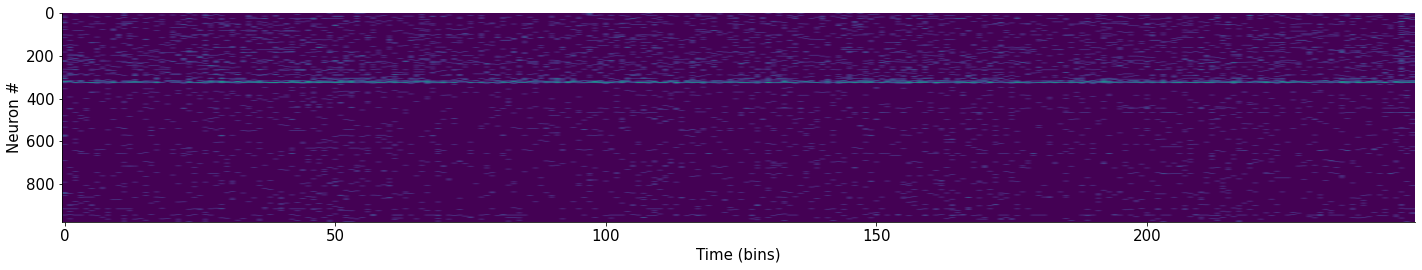

In [11]:
s31=SteinmetzSession(alldat[30])
## plot a trial
s31.plotTrial(42)
### print areas
s31.get_areas()

 removing data from 696 neurons not contained in MOs 
neurons remaining in trial 281


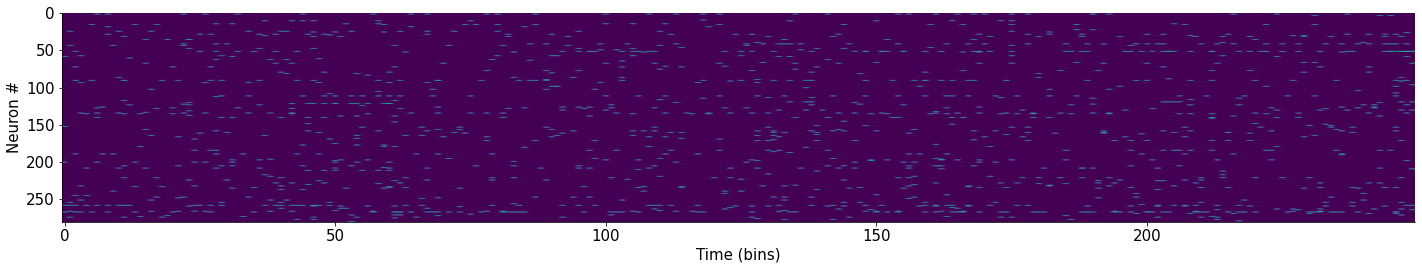

In [12]:
###remove all neurons not in motor cortex
s31.extractROI('MOs')
### plot a trial from motor neuron
s31.plotTrial(42)

In [35]:
s31.data['spks'].mean(0).shape


(237, 250)

In [13]:
# s31.FlattenTs()

In [14]:
#@title Set up Dataset

### dataset definition
class NeuronDataset(Dataset):
  def __init__(self, X, Y):
    self.X = X
    self.Y = Y
    
  def __len__(self):
    return len(self.Y)
    
  def __getitem__(self, idx):
    dataP = self.Y[idx]
    data = self.X[idx]
    sample = {"X": data, "Y": dataP}
    return sample

#### input the permuted matrix which places trial as first dimension
##### this dataset compares session 31 to session 31 motor corte on X and Y 
ND=NeuronDataset(s31.trials_first(),s31.trials_first()) 

In [37]:
ND[0]


{'X': tensor([[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]], dtype=torch.int8),
 'Y': tensor([[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]], dtype=torch.int8)}

In [26]:
#@title Split Dataset and Create Data Loaders  
def split_dataset(ds,tr,v):
  tra= int(np.floor(len(ds)*tr))
  va = int(np.floor(len(ds)*v))
  ts= int(len(ds)-tra-va)
  train,val,test=torch.utils.data.random_split(ND,[tra,va,ts]) # split across dim 0
  return train,val,test

traindata,valdata,testdata =split_dataset(ND,0.6,0.3)

#### set up dataloaders
DL_Train = DataLoader(traindata, batch_size=20)
DL_Val = DataLoader(valdata, batch_size=20)
DL_Test = DataLoader(testdata, batch_size=20)

In [17]:
#### check that the data loader is iterating correctly 
print('\nFirst iteration of data set: ', next(iter(valdata)), '\n')
print('Length of data set: ', len(traindata), '\n')


First iteration of data set:  {'X': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 1,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], dtype=torch.int8), 'Y': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 1,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], dtype=torch.int8)} 

Length of data set:  142 



In [22]:
# time * trial * neuron
next(iter(valdata))['X'].shape
next(iter(valdata))['Y'].shape

torch.Size([281, 250])

In [24]:
class Net(nn.Module): # our model
  def __init__(self, ncomp, NN1, NN2, bidi=True):
    super(Net, self).__init__()

    # play with some of the options in the RNN!
    self.rnn1 = nn.RNN(NN1, ncomp, num_layers = 1, dropout = 0, # MO
                      bidirectional = bidi, nonlinearity = 'tanh')
    self.rnn2 = nn.RNN(NN2,ncomp,num_layers = 1, dropout = 0, bidirectional = bidi, nonlinearity = 'tanh') #TH

    self.fclatent = nn.Linear(ncomp,ncomp)
    self.fc = nn.Linear(ncomp,NN1)

  def forward(self, x0,x1):
    print(x1)

    y2 = self.rnn2(x0)[0] # ncomp TH
    y =  self.rnn1(x1)[0] # ncomp MOs
    y += self.fclatent(y2) # ncomp MOs with projection of latent TH components

    if self.rnn.bidirectional:
      # if the rnn is bidirectional, it concatenates the activations from the forward and backward pass
      # we want to add them instead, so as to enforce the latents to match between the forward and backward pass
      q = (y[:, :, :ncomp] + y[:, :, ncomp:])/2
    else:
      q = y

    # the softplus function is just like a relu but it's smoothed out so we can't predict 0
    # if we predict 0 and there was a spike, that's an instant Inf in the Poisson log-likelihood which leads to failure
    z = F.softplus(self.fc(q), 10)

    return z, q

In [23]:
# input here:
ncomp = 10
NN1 = len(DL_Train)
NN2 = 100



In [28]:
# we initialize the neural network

net_baseline = Net(ncomp, NN1, NN2, bidi = True).to(device)
net_baseline.fclatent.weight.data[:] = 0
net_baseline.fclatent.bias.data[:] = 0
net_baseline.fclatent.weight.require_grad = False
net_baseline.fclatent.bias.require_grad = False

# special thing:  we initialize the biases of the last layer in the neural network
# we set them as the mean firing rates of the neurons.
# this should make the initial predictions close to the mean, because the latents don't contribute much
net_baseline.fc.bias.data[:] = x1.mean((0,1))


# we set up the optimizer. Adjust the learning rate if the training is slow or if it explodes.
optimizer = torch.optim.Adam(net_baseline.parameters(), lr=.005)

print(net_baseline)

NameError: ignored

In [ ]:
# (add code to train net_baseline)
# after training the baseline network, get the weights of rnn1 and freeze it
net_withinput  = copy.deepcopy(net_baseline)
net_withinput.fclatent.weight.require_grad = True
net_withinput.fclatent.bias.require_grad = True
net_withinput.rnn1.weight_ih_l0.require_grad = False
net_withinput.rnn1.weight_hh_l0.require_grad = False
net_withinput.rnn1.bias_ih_l0.require_grad = False
net_withinput.rnn1.bias_hh_l0.require_grad = False
net_withinput.rnn1.weight_ih_l0_reverse.require_grad = False
net_withinput.rnn1.weight_hh_l0_reverse.require_grad = False
net_withinput.rnn1.bias_ih_l0_reverse.require_grad = False
net_withinput.rnn1.bias_hh_l0_reverse.require_grad = False
print(net_withinput)

In [ ]:
for (idx, batch) in enumerate(DL_DS):
  pass
      # print(idx, 'X:', batch['X'])

In [ ]:
#Parameters
params = {'batch_size': 64,
          'shuffle': True,
          'num_workers': 6}
max_epochs = 100

# Datasets
partition = # IDs
labels = # Labels

# Generators
training_set = Dataset(partition['train'], labels)
training_generator = torch.utils.data.DataLoader(training_set, **params)

validation_set = Dataset(partition['validation'], labels)
validation_generator = torch.utils.data.DataLoader(validation_set, **params)

SyntaxError: ignored

In [22]:
import torch

# @title Set device (GPU or CPU). Execute `set_device()`

# inform the user if the notebook uses GPU or CPU.

def set_device():
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("WARNING: For this notebook to perform best, "
        "if possible, in the menu under `Runtime` -> "
        "`Change runtime type.`  select `GPU` ")
  else:
    print("GPU is enabled in this notebook.")

  return device



device = set_device()


GPU is enabled in this notebook.


In [23]:
# set the seed
np.random.seed(42)

# 100 trials is typical of neural data
ntrials = 100

# we simulate 200 neurons
NN = 200

# we will pretend like every "bin" is 10ms, so the trial length is 2500ms
NT = 250

# let's use 10 latent components
ncomp = 10

# this is the recurrent dynamics matrix, which we made diagonal for simplicity
# values have to be smaller than 1 for stability
A0 =  np.diag(.8 + .2 * np.random.rand(ncomp,))

# this is the projection matrix from components to neurons
C0 = .025 * np.random.randn(ncomp, NN)

# We generate the dynamics of the low-d system. We initialize the latent state.

# start by initializing the latents
y       = 2 * np.random.randn(ncomp)
latents = np.zeros((NT, ntrials, ncomp))
# we run the dynamics forward and add noise (or "innovations") at each timestep
for t in range(NT):
  y = y @ A0 +  np.random.randn(ntrials, ncomp)
  latents[t] = y

# we now project the latents to the neuron space and threshold to generate firing rates
rates = np.maximum(0, latents @ C0)

# now we draw poisson counts to simulate the number of spikes a neuron fires randomly
x = np.random.poisson(rates)
x0 = torch.from_numpy(x[:, :, :200]).to(device).float()
x1 = torch.from_numpy(x[:, :, 200:]).to(device).float()

x0 = torch.permute(x0, (2,1,0))
x0 = np.reshape(x0, (-1,200))


x1 = torch.permute(x1, (2,1,0))
x1 = np.reshape(x1, (-1,200))
print(x1.shape)

TypeError: ignored

In [ ]:
import torch
import torch.nn as nn
import torchvision 
class AE(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        self.encoder_hidden_layer = nn.Linear(
            in_features=kwargs["input_shape"], out_features=128
        )
        self.encoder_output_layer = nn.Linear(
            in_features=128, out_features=128
        )
        self.decoder_hidden_layer = nn.Linear(
            in_features=128, out_features=128
        )
        self.decoder_output_layer = nn.Linear(
            in_features=128, out_features=kwargs["input_shape"]
        )

    def forward(self, features):
        activation = self.encoder_hidden_layer(features)
        activation = torch.relu(activation)
        code = self.encoder_output_layer(activation)
        code = torch.relu(code)
        activation = self.decoder_hidden_layer(code)
        activation = torch.relu(activation)
        activation = self.decoder_output_layer(activation)
        reconstructed = torch.relu(activation)
        return reconstructed

In [ ]:
#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(np.shape(x0))

# create a model from `AE` autoencoder class
# load it to the specified device, either gpu or cpu
model = AE(input_shape=200).to(device)

# create an optimizer object
# Adam optimizer with learning rate 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# mean-squared error loss
criterion = nn.MSELoss()

torch.Size([25000, 200])


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torchvision.datasets.mnist.MNIST

In [ ]:
epochs = 100
for epoch in range(epochs):
    loss = 0

    # reshape mini-batch data to [N, 784] matrix
    # load it to the active device
    
    # reset the gradients back to zero
    # PyTorch accumulates gradients on subsequent backward passes
    optimizer.zero_grad()
    
    # compute reconstructions
    print(type(x0))
    outputs = model(x0)
    
    # compute training reconstruction loss
    train_loss = criterion(outputs, x0)
    
    # compute accumulated gradients
    train_loss.backward()
    
    # perform parameter update based on current gradients
    optimizer.step()
    
    # add the mini-batch training loss to epoch loss
    loss += train_loss.item()
    

    
    # display the epoch training loss
    print("epoch : {}/{}, loss = {:.6f}".format(epoch + 1, epochs, loss))

<class 'torch.Tensor'>
epoch : 1/100, loss = 0.114980
<class 'torch.Tensor'>
epoch : 2/100, loss = 0.114161
<class 'torch.Tensor'>
epoch : 3/100, loss = 0.113437
<class 'torch.Tensor'>
epoch : 4/100, loss = 0.112906
<class 'torch.Tensor'>
epoch : 5/100, loss = 0.112515
<class 'torch.Tensor'>
epoch : 6/100, loss = 0.112154
<class 'torch.Tensor'>
epoch : 7/100, loss = 0.111754
<class 'torch.Tensor'>
epoch : 8/100, loss = 0.111305
<class 'torch.Tensor'>
epoch : 9/100, loss = 0.110838
<class 'torch.Tensor'>
epoch : 10/100, loss = 0.110377
<class 'torch.Tensor'>
epoch : 11/100, loss = 0.109895
<class 'torch.Tensor'>
epoch : 12/100, loss = 0.109346
<class 'torch.Tensor'>
epoch : 13/100, loss = 0.108746
<class 'torch.Tensor'>
epoch : 14/100, loss = 0.108141
<class 'torch.Tensor'>
epoch : 15/100, loss = 0.107535
<class 'torch.Tensor'>
epoch : 16/100, loss = 0.106912
<class 'torch.Tensor'>
epoch : 17/100, loss = 0.106286
<class 'torch.Tensor'>
epoch : 18/100, loss = 0.105669
<class 'torch.Tenso

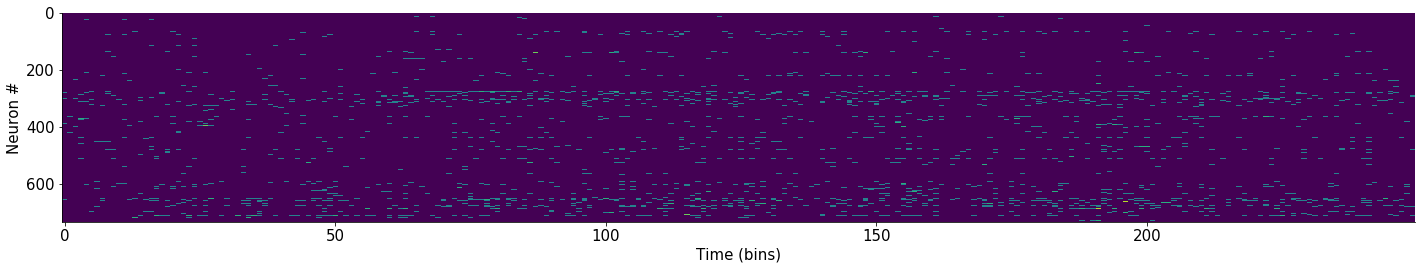

In [ ]:
s1.plotTrial(1)


range(0, 251, 10)
Binned spikes, turning a (734, 214, 250) matrix into a (734, 214, 25) matrix


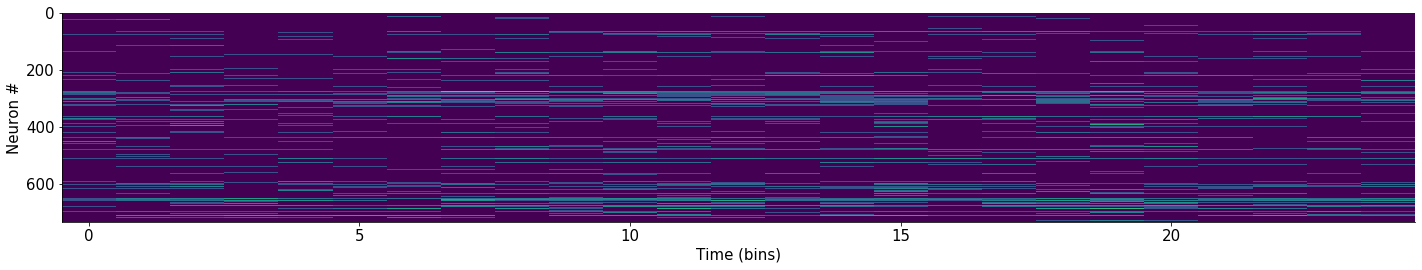

In [ ]:
s1.binData(10)
s1.plotTrial(1)